![logo](../LogoLine_horizon_C3S.png)

# Producing the ENSO index verification heatmaps

In this example we use the computed El Niño–Southern Oscillation (ENSO) indices from [the previous Notebook](enso_index_from_cds_data.ipynb) to produce heatmaps of temporal correlations, as included on the C3S seasonal [verification page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots). 

Some information on ENSO impacts in Europe can be found on [a page in the C3S documentation](https://confluence.ecmwf.int/display/COPSRV/ENSO+impacts+on+Europe).

## Configuration

Import required modules and define some parameters related to the indices previously computed.

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from dateutils import relativedelta

# dictionary of systems, versions and attributes
providers = {
    'ecmf.s51': {'cds_name': 'ecmwf', 'plot_name': 'ECMWF', 'plot_system': 'SEAS5', 'cds_system': '51', 'hcsize': 25,
                 'fcsize': 51, 'lagged': False},
    'lfpw.s8': {'cds_name': 'meteo_france', 'plot_name': 'Météo-France', 'plot_system': 'System 8', 'cds_system': '8',
                'hcsize': 25, 'fcsize': 51, 'lagged': False},
    'egrr.s602': {'cds_name': 'ukmo', 'plot_name': 'Met Office', 'plot_system': 'GloSea6', 'cds_system': '602',
                  'hcsize': 28, 'fcsize': 60, 'lagged': True},
    # 'egrr.s603': {'cds_name': 'ukmo', 'plot_name': 'Met Office', 'plot_system': 'GloSea6', 'cds_system': '603',
    #               'hcsize': 28, 'fcsize': 60, 'lagged': True},
    'edzw.s21': {'cds_name': 'dwd', 'plot_name': 'DWD', 'plot_system': 'GCFS2.1', 'cds_system': '21', 'hcsize': 30,
                 'lagged': False},
    'cmcc.s35': {'cds_name': 'cmcc', 'plot_name': 'CMCC', 'plot_system': 'SPS3.5', 'cds_system': '35', 'hcsize': 40,
                 'fcsize': 50, 'lagged': False},
   'kwbc.s2': {'cds_name': 'ncep', 'plot_name': 'NCEP', 'plot_system': 'CFSv2', 'cds_system': '2', 'hcsize': 20,
               'lagged': True},
    'rjtd.s3': {'cds_name': 'jma', 'plot_name': 'JMA', 'plot_system': 'CPS3', 'cds_system': '3', 'hcsize': 10,
                'fcsize': 150, 'lagged': True},
    'cwao.s2': {'cds_name': 'eccc', 'plot_name': 'ECCC', 'plot_system': 'CanCM4i', 'cds_system': '2', 'hcsize': 10,
                'fcsize': 10, 'lagged': False},
    'cwao.s3': {'cds_name': 'eccc', 'plot_name': 'ECCC', 'plot_system': 'GEM5-NEMO', 'cds_system': '3', 'hcsize': 10,
                'fcsize': 10, 'lagged': False},
    # 'cwao.s4': {'cds_name': 'eccc', 'plot_name': 'ECCC', 'plot_system': 'CanESM5.1p1bc', 'cds_system': '4', 'hcsize': 10,
    #             'fcsize': 10, 'lagged': False},
    # 'cwao.s5': {'cds_name': 'eccc', 'plot_name': 'ECCC', 'plot_system': 'GEM5.2-NEMO', 'cds_system': '5', 'hcsize': 10,
    #             'fcsize': 10, 'lagged': False},
}

# select a system and version
prov = 'lfpw.s8'
centre = providers[prov]['cds_name']
version = providers[prov]['cds_system']
# define the common hindcast period
hc_period = ['1993', '2016']
hc_str = '_'.join([hc_period[0], hc_period[1]])
# the data path where the indices were saved
data_path = '/data'

## Load the pre-computed ERA5 indices and prepare to compute correlations

In [9]:
# load in reanalysis
era5_file_name = '/era_5_nino_ind_1993_2016.nc'
era5_ind = xr.open_dataarray(data_path + era5_file_name)
era5_ind
# create a correlation array
corr = xr.Dataset()

## Loop over the hindcast start months and compute correlations

Loop over the start months. For each start month do the following:
* deal with the missing Jan 1993 start if the centre is `ukmo`
* create a copy of the ERA5 array (to rearrange to match the valid times of the start month in question)
* read in the hindcast index for the given start, and refactor to include valid time
* sub-select [qualifying ensemble members](https://confluence.ecmwf.int/display/CKB/Summary+of+available+data#:~:text=per%20forecast%20system-,Nominal%20Start%20Dates,-For%20systems%20with), if needed (for lagged start systems where not all dates are used in the graphical products)
* refactor the ERA5 array to allign with the hindcast leadtimes 
* for each leadmonth compute the temporal correlation
* combine the lead month correlations and append to the array of correlations by start month

The result is an array of temporal correlations for each start month and lead month.

In [21]:
for stmonth in range(1, 13):
    print('START MONTH = {}'.format(stmonth))
    # Note that if the chosen system does not yet have all starts then this needs to be dealt with here
    # This also includes January 1993 for UKMO meaning the ERA5 data needs to be adjusted to match this
    # Met office systems missing data - start month
    if centre == 'ukmo' and stmonth == 1:
        # edit config to deal with Jan 1993 data gap in met office data
        hc_period[0] = '1994'
        o = era5_ind.sel(time=slice(hc_period[0], hc_period[1])).copy()
    else:
        o = era5_ind.copy()

    # READ HCST DATAFRAME FOR GIVEN START
    hc_file_name = '/{}_mm_{}_{}_{}_st_{}_nino_ind.nc'.format('sst', centre, version, hc_str, stmonth)
    hcst = xr.open_dataarray(data_path + hc_file_name)
    hcst = hcst.rename({'time': 'start_date'})

    #hcst = hcst.reset_coords(names="valid_time", drop=True)
    vt = xr.DataArray(dims=('start_date', 'forecastMonth'),
                      coords={'forecastMonth': hcst.forecastMonth, 'start_date': hcst.start_date})
    vt.data = [[pd.to_datetime(std) + relativedelta(months=fcmonth - 1) for fcmonth in vt.forecastMonth.values] for
               std
               in vt.start_date.values]
    hcst = hcst.assign_coords(valid_time=vt)
    # select qualifying ensemble members
    if prov == 'kwbc.s2':  # Only case where member sub-selection is needed from the CDS data
        hcst = hcst.sel(number=slice(None, 19))

    # refactor reanalysis to allign with hindcast leadtimes
    o = o.rename({'time': 'start_date'}).swap_dims({'start_date': 'valid_time'})
    fcmonths = [mm + 1 if mm >= 0 else mm + 13 for mm in
                [t.month - stmonth for t in pd.to_datetime(o.valid_time.values)]]
    o = o.assign_coords(forecastMonth=('valid_time', fcmonths))
    o = o.loc[(o['forecastMonth'] <= 6)]
    
    # loop over forecast month, define the hindcast mean over the ensemble members, and compute the correlation over the hindcast years
    l_corr = list()
    l_corr_det = list()
    for this_fcmonth in hcst.forecastMonth.values:
        thishcst = (hcst.sel(forecastMonth=this_fcmonth).swap_dims({'start_date': 'valid_time'}))
        thishcst = thishcst.mean('number')
        thisobs = o.where(o.valid_time == thishcst.valid_time, drop=True)
        l_corr.append(xr.corr(thishcst, thisobs, dim='valid_time'))
        
    thiscorr = xr.concat(l_corr, dim='forecastMonth')
    thiscorr = thiscorr.assign_coords(forecastMonth=[1, 2, 3, 4, 5, 6])
    thiscorr = thiscorr.expand_dims(dim={'start_month': [stmonth]}, axis=0)
    corr = xr.merge([corr, thiscorr])

START MONTH = 1
START MONTH = 2
START MONTH = 3
START MONTH = 4
START MONTH = 5
START MONTH = 6
START MONTH = 7
START MONTH = 8
START MONTH = 9
START MONTH = 10
START MONTH = 11
START MONTH = 12


Save the result, and inspect it.

In [22]:
file_name = '/{}_mm_{}_{}_{}_nino_ind_corr.nc'.format('sst', centre, version, hc_str)
corr.to_netcdf(data_path + file_name, mode='w')
corr

<xarray.Dataset> Size: 3kB
Dimensions:        (start_month: 12, region: 4, forecastMonth: 6)
Coordinates:
  * start_month    (start_month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * region         (region) int64 32B 0 1 2 3
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
    surface        float64 8B 0.0
    abbrevs        (region) <U3 48B '1+2' '3' '3.4' '4'
    names          (region) <U7 112B 'NINO1+2' 'NINO3' 'NINO3.4' 'NINO4'
    number         int64 8B 0
    step           timedelta64[ns] 8B 00:00:00
Data variables:
    sst            (start_month, forecastMonth, region) float64 2kB 0.8843 .....

## Plot the correlation heatmaps

Using the computed correlations, construct correlation heatmaps for each NINO index computed in the previous Notebook.

Define labels for the valid months or start months, and load the correlations.

In [23]:
# month labels for the plots
mon_labels = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# load the correlations
file_name = '/{}_mm_{}_{}_{}_nino_ind_corr.nc'.format('sst', centre, version, hc_str)
corr = xr.open_dataarray(data_path + file_name)

Loop over the regions for which the indices and correlations were computed:
* refactor the correlations for each region/index in a pandas dataframe (remove unnecessary dimensions and variables)
* plot correlation as a function of start month and leadtime using a [seaborn heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
* refactor the correlations again to include valid month instead of start month
* plot correlation as a function of valid month and leadtime

0 NINO1+2


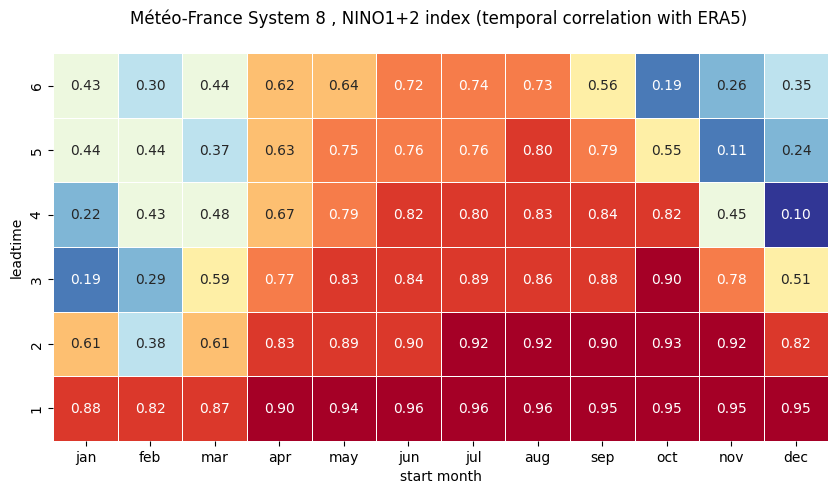

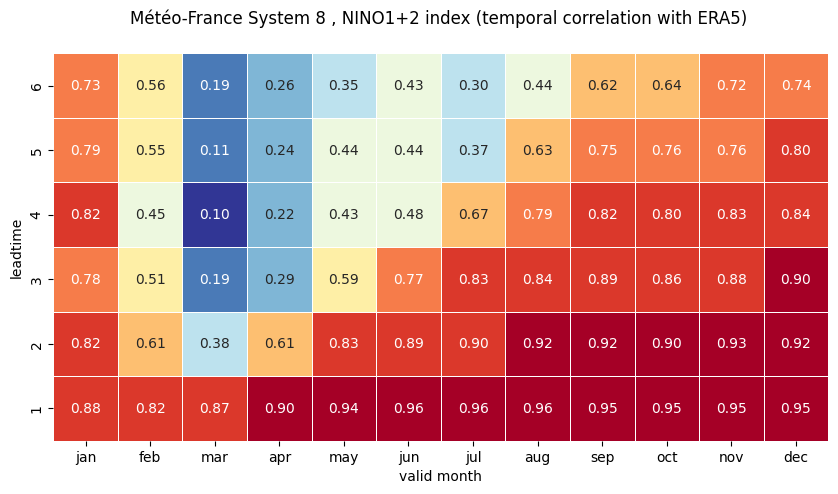

1 NINO3


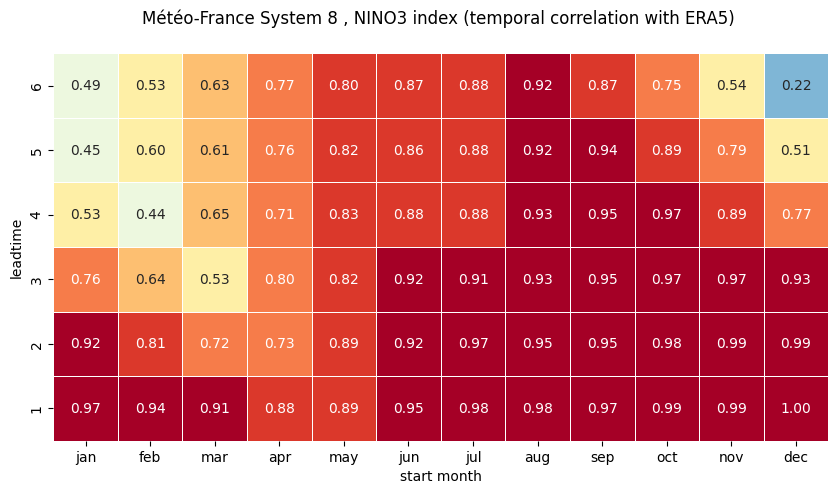

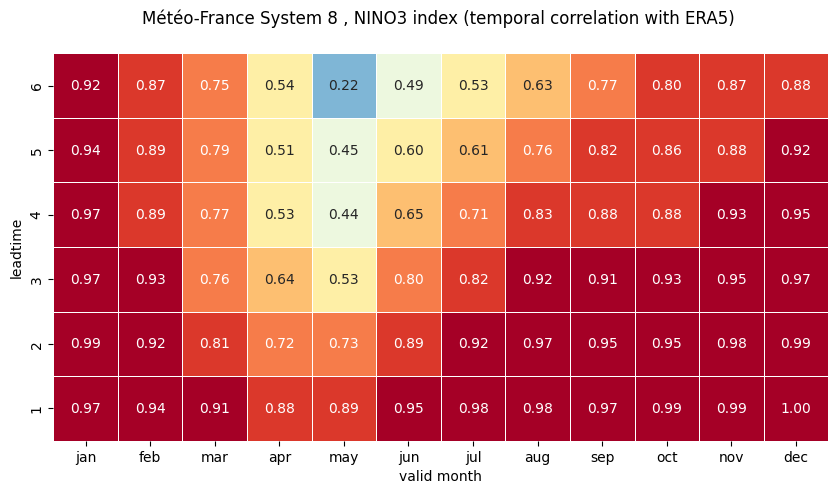

2 NINO3.4


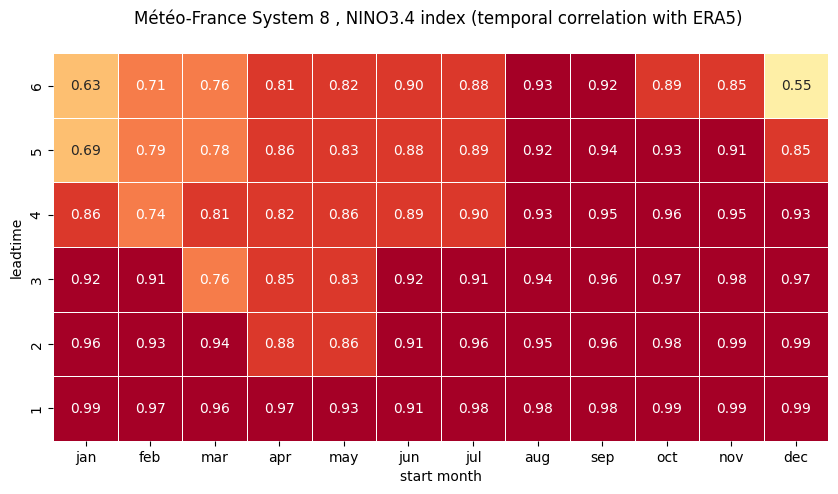

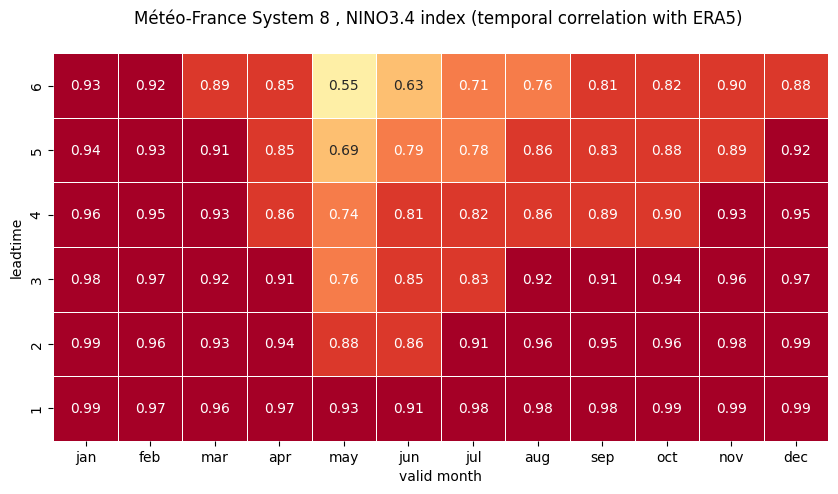

3 NINO4


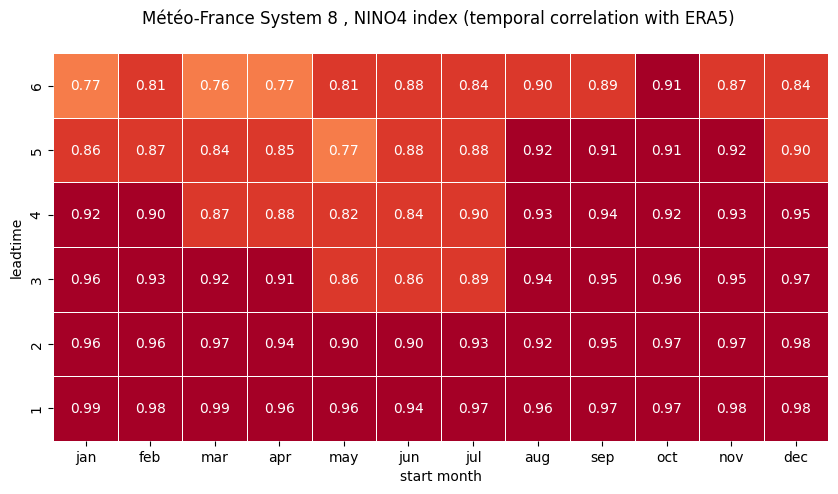

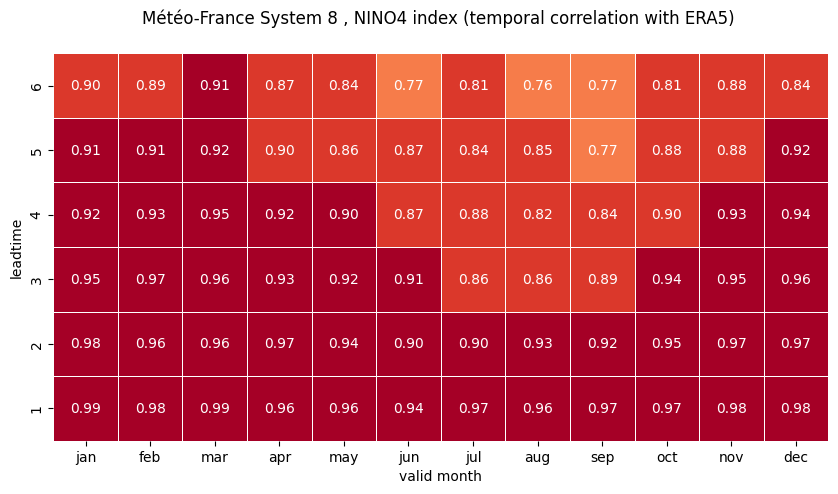

In [25]:
# make the plot - loop over nino regions
for ind in corr.region.values:
    print(ind, corr.sel(region=ind).names.values)
    ind_name = str(corr.sel(region=ind).names.values)
    hm_cm = plt.get_cmap('RdYlBu_r')
    hm_levs = np.linspace(0, 1, 11)
    norm = BoundaryNorm(hm_levs, ncolors=hm_cm.N, clip=True)

    # HEATMAP (correlation as a function of start_month and leadtime)
    df = (corr.sel(region=ind).to_dataframe()
          .drop(['region', 'surface', 'abbrevs', 'step', 'names', 'number'], axis=1))
    df = df.unstack().droplevel(0, axis=1)
    fig = plt.figure(figsize=(10, 10))
    ax = sns.heatmap(df.T, square=True, cmap=hm_cm, vmin=hm_levs.min(), vmax=hm_levs.max(), norm=norm,
                     linewidth=0.5,
                     annot=True, fmt=".2f", cbar=False)
    ax.invert_yaxis()

    tit_txt1 = '{} index (temporal correlation with ERA5) '.format(ind_name)
    if centre == 'ukmo':
        tit_txt2 = '{} {} (system={}), '.format(providers[prov]['plot_name'], providers[prov]['plot_system'],
                                                providers[prov]['cds_system'])
    if prov == 'ecmwf.51':
        tit_txt2 = '{} {} (C3Sv{}), '.format(providers[prov]['plot_name'], providers[prov]['plot_system'],
                                             providers[prov]['cds_system'])
    else:
        tit_txt2 = '{} {} , '.format(providers[prov]['plot_name'], providers[prov]['plot_system'])
    plt.title('\n'.join([tit_txt2 + tit_txt1, '']))
    plt.xlabel('start month')
    plt.ylabel('leadtime')
    # Set ticks labels for x-axis
    ax.set_xticklabels(mon_labels)  
    ax.set_yticklabels(['1', '2', '3', '4', '5', '6'])
    plt.show()

    # HEATMAP (correlation as a function of valid_month and leadtime)
    df_vt = df.stack(future_stack=True).reset_index()
    df_vt['valid_month'] = df_vt.apply(lambda row: row['start_month'] + row['forecastMonth'] - 1, axis=1).astype(
        'int32')
    df_vt['valid_month'] = [int(mm) if mm < 13 else mm - 12 for mm in df_vt['valid_month']]
    df_vt = df_vt.drop('start_month', axis=1).set_index(
        ['valid_month', 'forecastMonth']).unstack().transpose().droplevel(0)
    fig = plt.figure(figsize=(10, 10))
    ax = sns.heatmap(df_vt, square=True, cmap=hm_cm, vmin=hm_levs.min(), vmax=hm_levs.max(), norm=norm,
                     linewidth=0.5,
                     annot=True, fmt=".2f", cbar=False)
    ax.invert_yaxis()
    plt.title('\n'.join([tit_txt2 + tit_txt1, '']))
    plt.xlabel('valid month')
    plt.ylabel('leadtime')
    # Set ticks labels for x-axis
    ax.set_xticklabels(mon_labels)  # , rotation='vertical', fontsize=18)
    plt.show()

Extensions to these single-system monthly correlations heatmaps would be to compute indices for multiple systems and then combine them into multi-system combinations. The approach to variance-normalisation in the C3S SST index charts is outlined on the [products description page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecast+product+descriptions), and in the [SEAS5 user guide](https://www.ecmwf.int/sites/default/files/elibrary/2021/81237-seas5-user-guide_1.pdf). 